In [2]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

In [4]:
load_dotenv()

True

In [5]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0)

In [41]:
# Tools

search_tool = DuckDuckGoSearchRun(region="us")


@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    A simple calculator tool that can perform basic arithmetic operations like addition,
    subtraction, multiplication, and division.
    """
    if operation == "addition" or operation == "add":
        return {"result": first_num + second_num}
    elif operation == "subtraction" or operation == "subtract":
        return {"result": first_num - second_num}
    elif operation == "multiplication" or operation == "multiply":
        return {"result": first_num * second_num}
    elif operation == "division" or operation == "divide":
        if second_num == 0:
            return {"error": "Division by zero is not allowed."}
        return {"result": first_num / second_num}
    else:
        return {
            "error": "Invalid operation. Please use add, subtract, multiply, or divide."
        }


@tool
def get_stock_price(ticker: str) -> dict:
    """
    A tool to get the current stock price of a given ticker symbol.
    eg: AAPL, GOOGL, MSFT, AMZN
    """
    # For demonstration purposes, we'll return a mock price.
    # In a real implementation, you would fetch the price from a financial API.
    mock_prices = {"AAPL": 150.25, "GOOGL": 2750.50, "MSFT": 299.00, "AMZN": 3400.75}
    price = mock_prices.get(ticker.upper(), None)
    if price is not None:
        return {"ticker": ticker.upper(), "price": price}
    else:
        return {"error": "Ticker symbol not found."}


In [34]:
tools = [search_tool, calculator, get_stock_price]
tool_node = ToolNode(tools=tools)
llm_with_tools = llm.bind_tools(tools)

In [35]:
class MemoryState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]


def Agent(state: MemoryState) -> MemoryState:
    chat = state["messages"]
    response = llm_with_tools.invoke(chat)
    return {"messages": [response]}

In [36]:
graph = StateGraph(MemoryState)

#nodes
graph.add_node("Agent", Agent)
graph.add_node("tools", tool_node)

#edges
graph.add_edge(START, "Agent")
graph.add_conditional_edges(
    "Agent",
    tools_condition
)

graph.add_edge("tools", "Agent")
graph.add_edge("Agent", END)

In [37]:
chatbot = graph.compile()

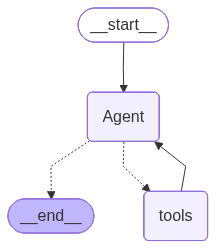

In [38]:
chatbot

In [52]:
response = chatbot.invoke({
    "messages": [HumanMessage(content="Chess player who died") ]
})
response

{'messages': [HumanMessage(content='Chess player who died', additional_kwargs={}, response_metadata={}, id='a9a15903-eead-4506-8290-82cce4ccde9b'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'duckduckgo_search', 'arguments': '{"query": "Chess player who died"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': []}, id='run--e09d4fd6-88f8-481b-940e-bf8380cb0c10-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Chess player who died'}, 'id': '87d53f3b-6898-46ec-aca0-52498c01f377', 'type': 'tool_call'}], usage_metadata={'input_tokens': 201, 'output_tokens': 20, 'total_tokens': 221, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='13 hours ago · Daniel Naroditsky, an American chess grandmaster who attracted a massive online following through his livestreamed play and accessible teachings, has died at 29. 13 hours ago 

In [ ]:
response['messages'][-1].content

'The user is asking a question about a chess player who died. The search results indicate that Daniel Naroditsky, an American chess grandmaster, has died at the age of 29. The search results also mention that his family announced his unexpected death.\n\nWould you like to know more about Daniel Naroditsky?'

: 